# Fitting of experimental chemical kinetics data
You perform some experiments in a batch reactor to determine the rate expression and thermochemistry for the reversible chemical reaction
$\require{mhchem}$
$$\ce{A <=> B}$$

Recall from thermodynamics that 
$\Delta G = \Delta H - T \Delta S$
and $\Delta G = R T \ln K_a$
where $K_a$ is the activity-based equilibrium constant of the chemical reaction, $R$ is the molar gas constant (8.314 J/mol/K) and $T$ is the temperature in Kelvin.

If we assume ideal solution (unit fugacity coefficients) then $K_a = K_c$ giving us the concentration-based equilibrium constant $K_c$. 
From kinetics you recall
$K_c = \frac{k_f}{k_r}$ 
where 
$k_f$ is the forward rate coefficient and $k_r$ is the reverse rate coefficient.
i.e. the rate of the reaction $\ce{A->B}$ is $k_f \times C_A$
and the reverse reaction $\ce{B->A}$ is $k_r \times C_B$
where $C_A$ and $C_B$ are the concentrations of species A and B respectively. 
In a batch reactor $\frac{dN_A}{dt} = r_{A(net)} V$, so (dividing through by the reactor volume $V$) $\frac{dC_A}{dt} = r_{A(net)}$ where $r_{A(net)}$ is the net rate of formation of species A, i.e. $r_{A(net)} = k_r C_B - k_f C_A$.
Assume the forward rate coefficient $k_f$ follows Arrhenius form, $k_f = A \exp\left(\frac{-E_A}{R T}\right)$ where $A$ is the "pre-exponential factor" and $E_A$ is the activation energy.

Fortunately, in this case you have good reason to believe that species A and B have very similar temperature-dependent heat capacities, so that $\Delta H_{rxn}$ and $\Delta S_{rxn}$ are independent of temperature.

You start the experiment with no B ($C_B=0$), and at time zero have some way to initiate the reaction, starting with a set concentration of $C_A$. 

You wish to determine the four paramaters:
$log_{10} A$,
$E_A$,
$\Delta H_{rxn}$,
$\Delta S_{rxn}$.

Based on a literature search, quantum chemistry calculations, and prior experience, your current estimates are as follows:
```
logA = 6.  # base-ten logarithm of A in s^-1
Ea = 45.   # Ea in kJ/mol
dH = -10.  # ∆H in kJ/mol
dS = -50.  # ∆S in J/mol/K
```


In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

import random
import SALib as sa
import SALib.sample
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp


In [56]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("paper",rc={"figure.figsize": (2, 2)})

We create a "named tuple" data type to store the exprimental data in.

In [57]:
from collections import namedtuple
ExperimentData = namedtuple('ExperimentData', ['T', 'cA_start', 'times', 'cA'])

def plot_experiment(e):
    """
    Plots the experimental data provided in 'e' 
    which should be of the type ExperimentData.
    """
    plt.plot(0, e.cA_start, 'ko')
    plt.plot(e.times, e.cA,':o', label="T={:.0f}K".format(e.T))
    plt.ylim(0,)
    plt.ylabel('$C_A$ (mol/L)')
    plt.xlabel('time (s)')
    plt.legend()

Now here are the data from your three experiments:

Experiment 0 was at T=298.15K and ran for 100 seconds
Experiment 1 was at T=308.15K and ran for 100 seconds
Experiment 2 was at T=323.15K and ran for 100 seconds


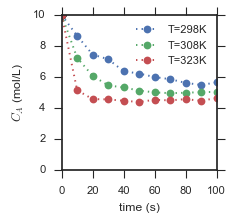

In [80]:
from numpy import array

# added zero point to improve fit
experiments = [ExperimentData(T=298.15, 
                              cA_start=10.0, 
                              times=array([ 0, 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 10, 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])), 
               ExperimentData(T=308.15, 
                              cA_start=10.0, 
                              times=array([ 0, 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 10, 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])), 
               ExperimentData(T=323.15, 
                              cA_start=10.0, 
                              times=array([ 0, 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 10, 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])),
              ]

for i,e in enumerate(experiments):
    print("Experiment {} was at T={}K and ran for {} seconds".format(i, e.T, e.times[-1]))
    plot_experiment(e)

In [81]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45. , # Ea in kJ/mol
    dH = -10. , # ∆H in kJ/mol
    dS = -50.  # ∆S in J/mol/K
    )

# This should end up with your optimized parameters
optimized_parameters = ParameterSet(0,0,0,0)


# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
standard_errors = ParameterSet(0,0,0,0)


In [82]:
R = 8.314

In [83]:
def concentrations(x):
    c = 10
    T = 298.15
    R = 8.314
    t = 20
    
    a = np.exp((x[2]*1000-T*x[3])/(R*T))
    k = (10**x[0])*np.exp(-x[1]*1000/(R*T))
    
    return c/(a+1)+(10-(c/(a+1)))*np.exp(-t*(a*k+k)/a)

In [84]:
problem = {
'num_vars': 4,
'names': ['logA', 'Ea', 'dH', 'dS'],
'bounds': [[0, 15],
[0, 100],
[-20, 0],
[-100, 0]],
'groups': None
}

In [85]:
X = ms.sample(problem, 1000, num_levels=4, grid_jump=2)

In [86]:
Y = np.zeros(len(X))
for i in range(len(X)):
    Y[i] = concentrations(X[i])

In [87]:
Si = ma.analyze(problem, X, Y, conf_level=0.68, print_to_console=True, num_levels=4, grid_jump=2)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
logA                                2.816     -2.816           0.160      4.964
Ea                                  6.650      6.650           0.197      6.316
dH                                  2.837     -2.837           0.138      4.294
dS                                  4.940      4.940           0.183      5.671


This shows that all of the parameters are important, I think. This was kind of hard to get to work because the documentation was pretty limited when it came to actual use or what these terms mean.

Ok, now insert some cells to determine the optimized_parameters and their standard_errors.

Parameter 0: 7.1957687731370115 +/- 187958.96358559045 (1 st. dev.)
Parameter 1: 51.20077013394707 +/- 1072811.9030912973 (1 st. dev.)
Parameter 2: -17.582382612622418 +/- nan (1 st. dev.)
Parameter 3: -57.4947988188988 +/- nan (1 st. dev.)


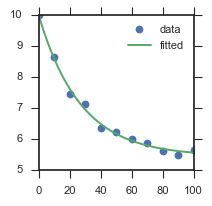

Parameter 0: 9.590069453864988 +/- 40261.392494842636 (1 st. dev.)
Parameter 1: 62.762486725421454 +/- 229799.58315383867 (1 st. dev.)
Parameter 2: -9.345874000526097 +/- nan (1 st. dev.)
Parameter 3: -31.348419987580538 +/- nan (1 st. dev.)


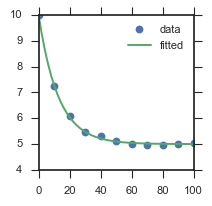

Parameter 0: 6.4869613377519295 +/- 221996.2147911906 (1 st. dev.)
Parameter 1: 42.30321756212341 +/- 1267085.610255217 (1 st. dev.)
Parameter 2: 7.104162827206379 +/- nan (1 st. dev.)
Parameter 3: 22.176017292413903 +/- nan (1 st. dev.)


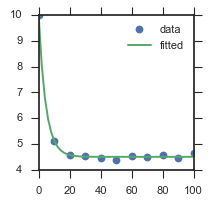

In [94]:
def concentration(t, logA, Ea, dH, dS):
    c = 10
    R = 8.314
    T = 298.15
    
    a = np.exp((dH*1000-T*dS)/(R*T))
    k = (10**logA)*np.exp(-Ea*1000/(R*T))
    
    return c/(a+1)+(10-(c/(a+1)))*np.exp(-t*(a*k+k)/a)

def report(optimal_parameters, covariance, a):
    "Make this a function so we can reuse it in cells below"
    parameter_errors = np.sqrt(np.diag(covariance))
    for i in range(len(optimal_parameters)):
        print("Parameter {}: {} +/- {} (1 st. dev.)".format(i,
                                                            optimal_parameters[i],
                                                            parameter_errors[i]))

    # Plot the data
    plt.plot(experiments[a].times, experiments[a].cA, 'o', label='data')

    # Make a new x array with 50 points for smoother lines
    x_many_points = np.linspace(experiments[a].times.min(),experiments[a].times.max(),50)
    # Plot the fitted curve
    plt.plot(x_many_points, concentration(x_many_points, optimal_parameters[0], 
                                          optimal_parameters[1], 
                                          optimal_parameters[2], 
                                          optimal_parameters[3]), label='fitted')
    # Add the legend, in the "best" location to avoid hiding the data
    plt.legend(loc='best')
    plt.show()


for i in range(3):
    # Fit the parameters to the imperfect x_data and y_data
    optimal_parameters, covariance = scipy.optimize.curve_fit(concentration,
                                                              experiments[i].times,
                                                              experiments[i].cA, 
                                                              p0=starting_guess)
    report(optimal_parameters, covariance, i)

In [96]:
# Finish your notebook with this cell
print(starting_guess)
print(optimized_parameters)
print(standard_errors)

ParameterSet(logA=6.0, Ea=45.0, dH=-10.0, dS=-50.0)
ParameterSet(logA=0, Ea=0, dH=0, dS=0)
ParameterSet(logA=0, Ea=0, dH=0, dS=0)


In [138]:
import numpy
import math
from scipy.optimize import leastsq

#+++++++++++++++++++++++++++++++++++++++++++++
def fit(x,T,A,n,m):
    return A/(n+1.0)*math.pow(T,(n+1.0))*numpy.power(x,m)

def concentration(t, T, params):
    c = 10
    R = 8.314
    
    logA, Ea, dH, dS = params
    
    a = np.exp((dH*1000-T*dS)/(R*T))
    k = (10**logA)*np.exp(-Ea*1000/(R*T))
    
    return c/(a+1)+(10-(c/(a+1)))*np.exp(-t*(a*k+k)/a)
#+++++++++++++++++++++++++++++++++++++++++++++
def leastsq_func(params, *args):
    cc=args[3]   #number of curves
    incs=args[11] #number of points 
    x=args[2]
    y=args[3]
    T=args[4:]

    A=params[0]
    n=params[1]
    m=params[2]

    yfit=numpy.empty(x.shape)
    for i in range(cc):
        v=i*incs
        b=(i+1)*incs
    if b<cc:
        yfit[v:b]=fit(x[v:b],T[i],A,n,m)
    else:
        yfit[v:]=fit(x[v:],T[i],A,n,m)

    return y-yfit
#+++++++++++++++++++++++++++++++++++++++++++++
Ts  = [expermiments[0].T, expermiments[1].T, expermiments[2].T]    #4 T-values for 4 curves
incs = 11                     #10 datapoints in each curve
x=
y=


params0=[0.001,1.01,-0.8]   #parameter guess

args=[len(Ts),incs,x,y]
for c in Ts:
    args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=leastsq(leastsq_func, params0, args=args)

TypeError: ufunc 'power' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [133]:
T = 298.15
Mat_tdata=[]
Mat_Cadata=[]

for i in range(3):
    Mat_tdata.append(experiments[i].times)
    Mat_Cadata.append(experiments[i].cA)

In [134]:
def concentration(t, T, par):
    c = 10
    R = 8.314
    
    logA, Ea, dH, dS = par
    
    a = np.exp((dH*1000-T*dS)/(R*T))
    k = (10**logA)*np.exp(-Ea*1000/(R*T))
    
    return c/(a+1)+(10-(c/(a+1)))*np.exp(-t*(a*k+k)/a)

def err (par,T,t,Ca):
    return concentration(t,T,par)-Ca

def err_global(par, Mat_t, Mat_Ca):
    err0=[]
    for i in range(0, len(Mat_t)):
        errc=err(par, T, Mat_t[i],Mat_Ca[i])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0

[ 1.          1.         -2.22358873 -5.86478939]


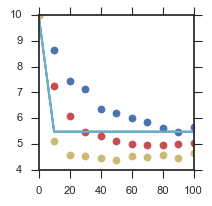

In [137]:
p_global=[1,1,1,1]
p_best,success=scipy.optimize.leastsq(err_global, p_global,args=(Mat_tdata,Mat_Cadata),maxfev=40000)
toplot=[]
for i in range(0,len(Mat_tdata)):
    toplot.append(concentration(Mat_tdata[i], T,p_best))
err_toplot=err_global(p_best, Mat_tdata,Mat_Cadata)
print(p_best)

for i in range(0,len(Mat_tdata)):
    plt.plot(Mat_tdata[i],Mat_Cadata[i],'o',Mat_tdata[i],toplot[i],'-')
plt.show()